## Objective:

Building a model to improve the Zestimate residual error(logerror).

## Import Libraries

In [96]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
import missingno as msno
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from sklearn.linear_model import LinearRegression

## Read train file

In [97]:
train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
print('Shape of train data: ', train.shape)

Shape of train data:  (90275, 3)


In [3]:
train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


## Analysing output variable(logerror)

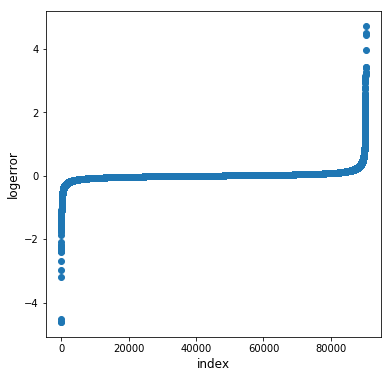

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(range(train.shape[0]), np.sort(train.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Looks nice with some outliers at both the ends. The graph of output has a shape of a tanh curve except the range of value is larger.

## Removing outlier values and analysing distribution of output variable(logerror)

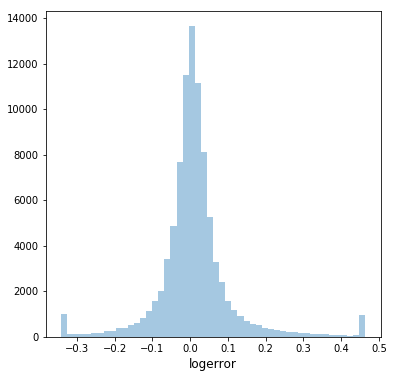

In [5]:
train['logerror'].loc[train['logerror']> np.percentile(train.logerror.values, 99)] = np.percentile(train.logerror.values, 99)
train['logerror'].loc[train['logerror']< np.percentile(train.logerror.values, 1)] = np.percentile(train.logerror.values, 1)

plt.figure(figsize=(6,6))
sns.distplot(train.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Nice normal distribution on the log error can be observed

## Checking the number of transactions in each month.

In [6]:
train['transaction_month'] = train['transactiondate'].dt.month

transac_month = train['transaction_month'].value_counts()
transac_month = transac_month.sort_index()
dic = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'July', 8: 'Aug', 9: 'Sep', 10:'Oct', 11:'Nov'
      ,12:'Dec'}

lis = []
for idx in transac_month.index:
    lis.append(dic[idx])

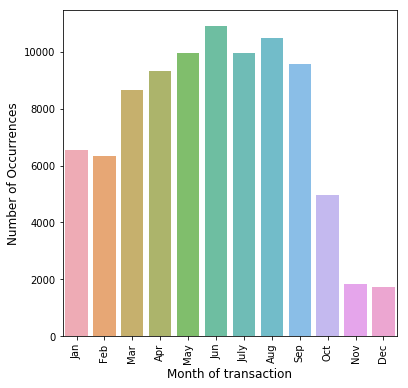

In [7]:
plt.figure(figsize=(6,6))
sns.barplot(lis, transac_month.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

So we have shorter bars in the last three months.

# Read properties file

In [8]:
properties = pd.read_csv('properties_2016.csv')

In [9]:
print("Shape Of Properties: ",properties.shape)

Shape Of Properties:  (2985217, 58)


## Lets Merge Train And Properties To Facilitate EDA

In [10]:
merged_df = pd.merge(train,properties,on="parcelid",how="left")

## Shape of merged data

In [11]:
merged_df.shape

(90275, 61)

## First Few Rows Of Data

In [12]:
merged_df.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
transaction_month,1,1,1
airconditioningtypeid,1,NaN,1
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2,3.5,3
bedroomcnt,3,4,2
buildingclasstypeid,NaN,NaN,NaN


## Visualizing Datatypes

[Text(0,0.5,'Count'),
 Text(0.5,0,'Variable Type'),
 Text(0.5,1,'Variables Count Across Datatype')]

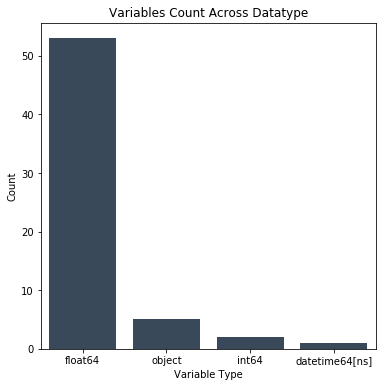

In [13]:
dataType = pd.DataFrame(merged_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(6,6)
sns.barplot(data=dataType,x="variableType",y="count",ax=ax,color="#34495e")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

Almost all are float variables with few object (categorical) variables.

## Missing value analysis

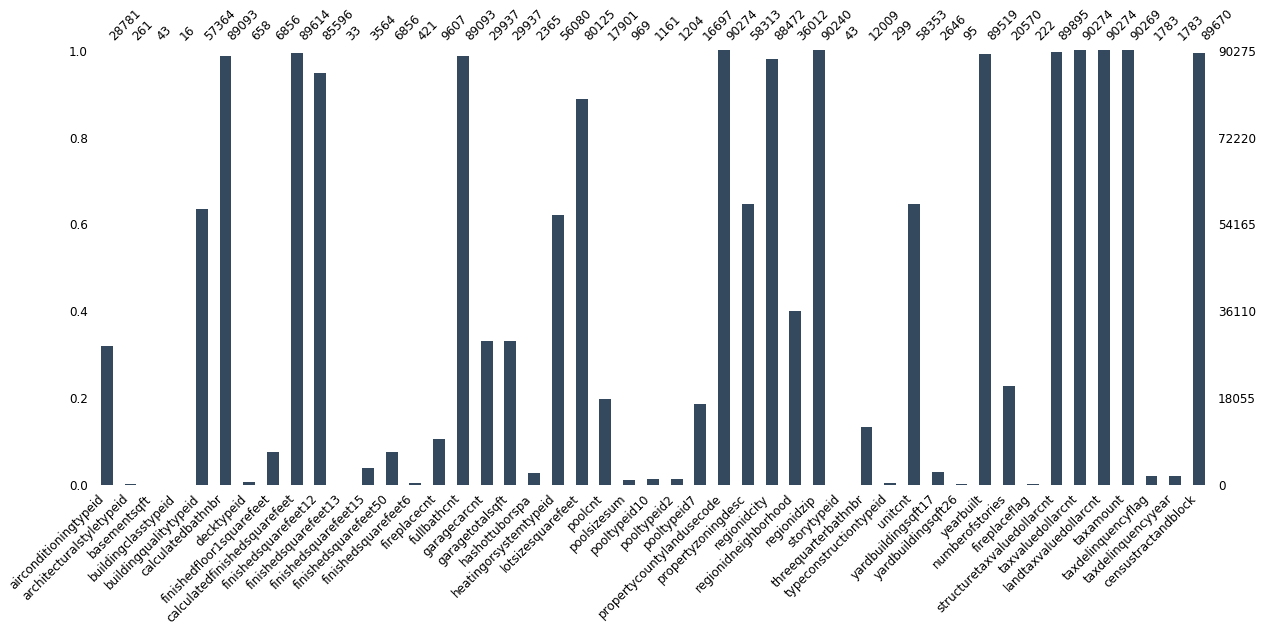

In [14]:
missingValueColumns = merged_df.columns[merged_df.isnull().any()].tolist()
msno.bar(merged_df[missingValueColumns],\
            figsize=(20,8),color="#34495e",fontsize=12,labels=True)

The data has a lot of missing values! 

## Correlation analysis of columns with missing values 

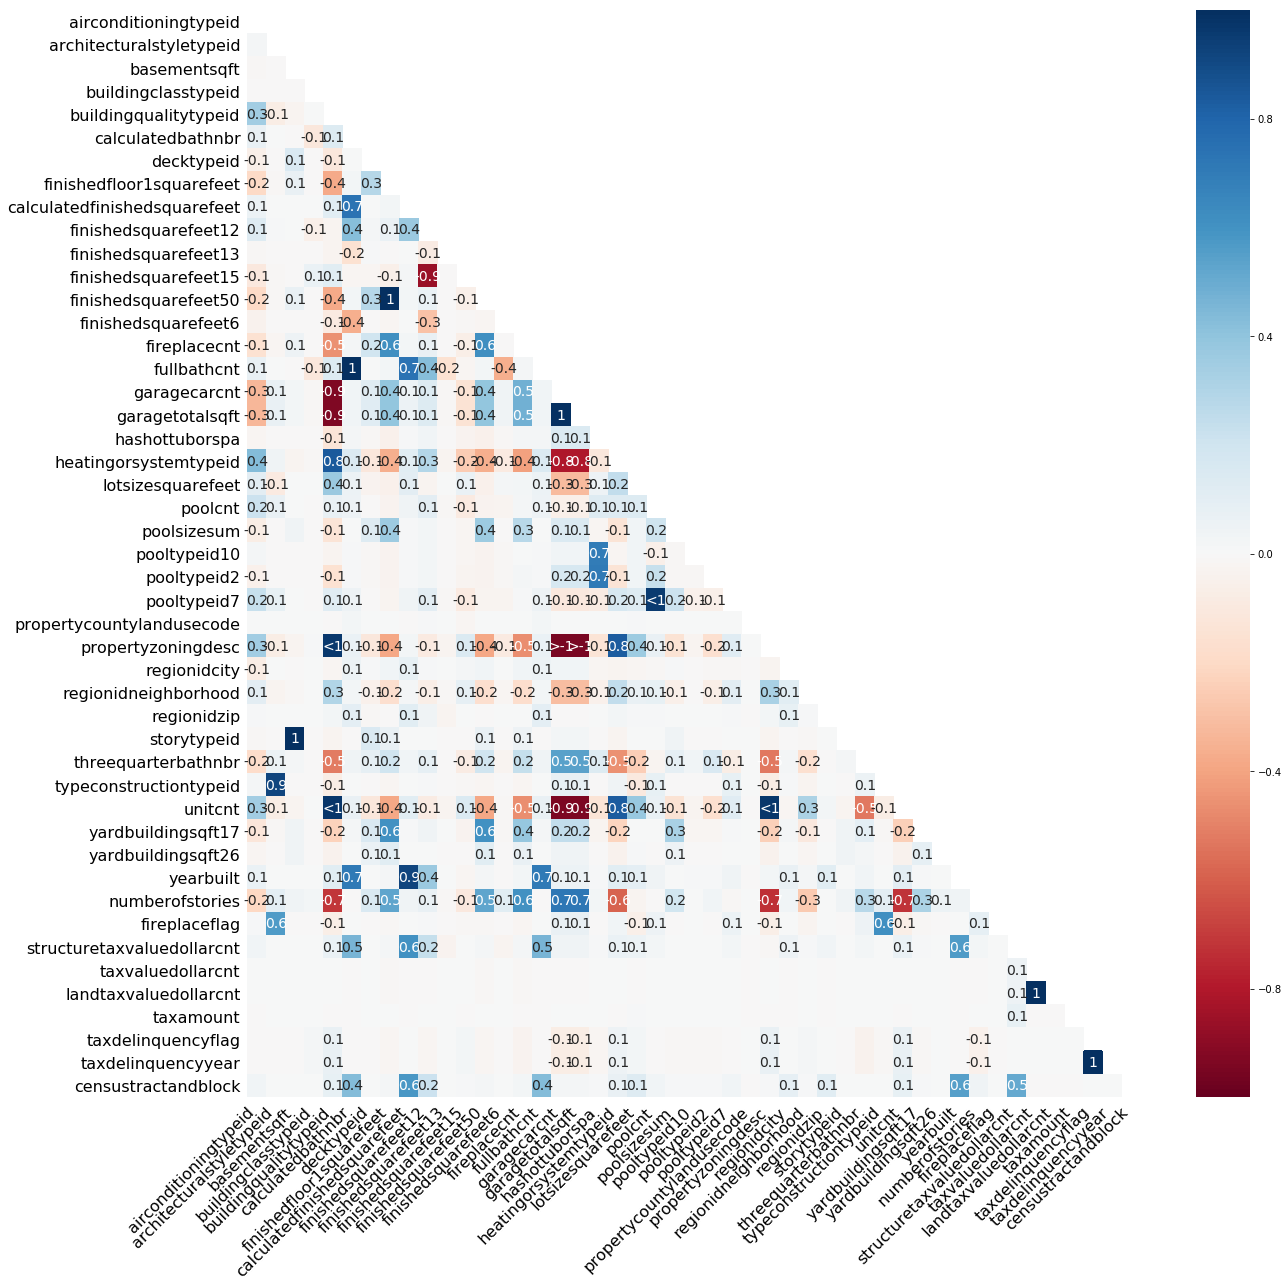

In [15]:
msno.heatmap(merged_df[missingValueColumns],figsize=(20,20))

## Columns with highest missing values

In [16]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / merged_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


These 4 columns have missing ratio of greater than 99%!

# Feature Engineering

## Top feature selection

In [17]:
mergedFilterd = merged_df.fillna(-1)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values)) 
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_x = mergedFilterd.drop(["parcelid", "transactiondate", "logerror", "transaction_month"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'seed' : 0
}


dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

[23:40:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=8
[23:40:19] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[23:40:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[23:40:2

[23:40:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[23:40:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[23:40:33] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=8
[23:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=8
[23:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=8
[23:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=8
[23:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=8
[23:40:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=8
[23:40:3

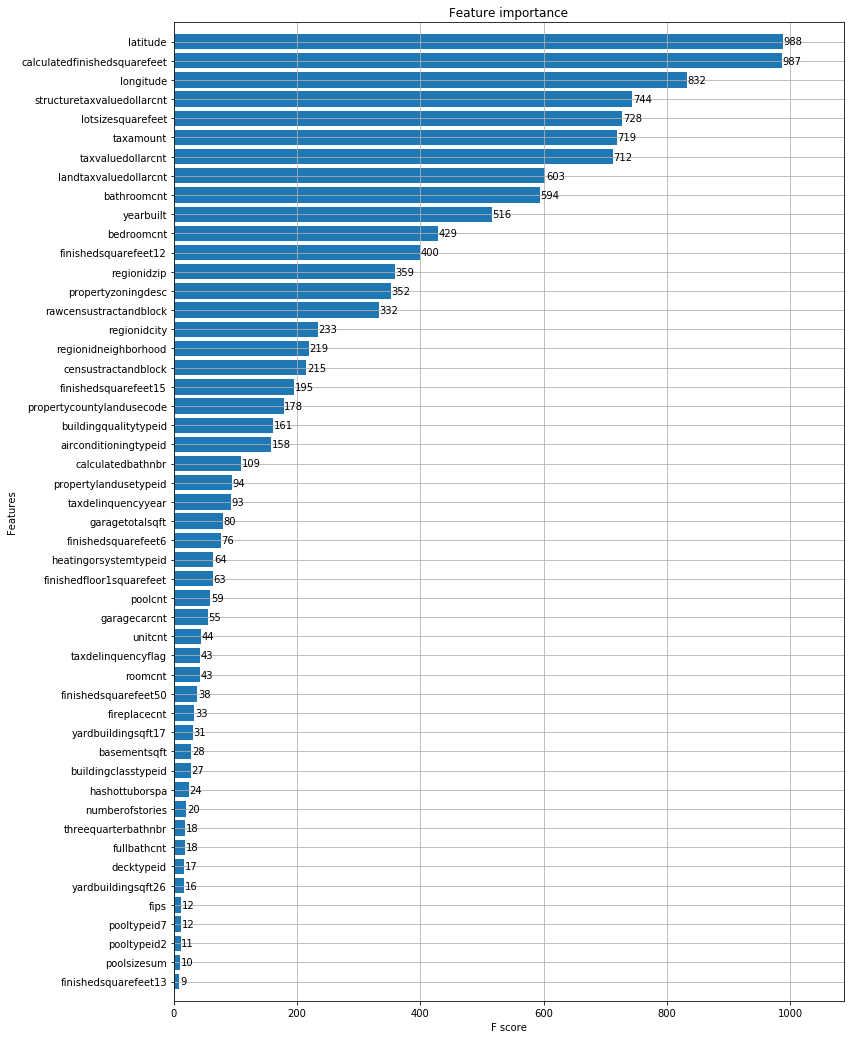

In [18]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

Using XGBoost, the important variables are 'latitude' followed by 'calculated finished square feet' and longitude

## Multicollinearity Analysis

In [28]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

In [29]:
numericalCol = []
for f in merged_df.columns:
    if merged_df[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror", "transaction_month"]:
        numericalCol.append(f)
mergedFilterd = merged_df[numericalCol].fillna(-1)
vifDict = calculate_vif_(mergedFilterd)

In [30]:
vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

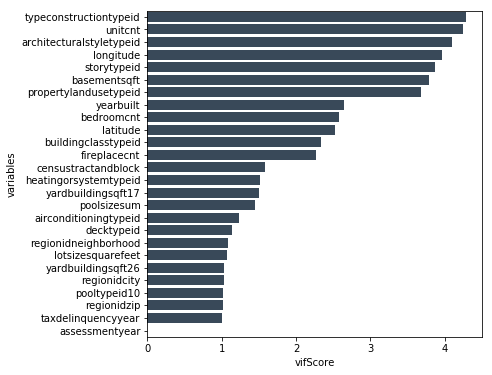

In [31]:
plt.figure(figsize=(6,6))
sns.barplot(data=validVariables,x="vifScore",y="variables",orient="h",color="#34495e")

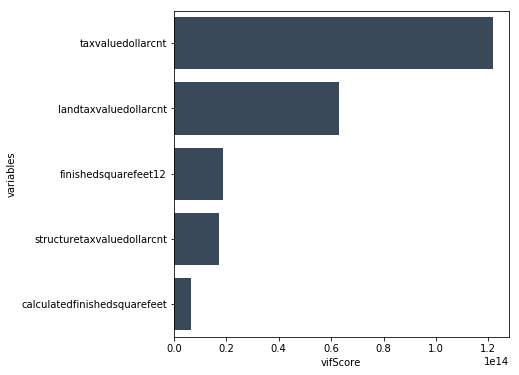

In [32]:
plt.figure(figsize=(6,6))
sns.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",orient="h",color="#34495e")

These are the variables which exhibit multicollinearity

## Correlation analysis of each varibale with target variable

In [37]:
mean_values = merged_df.mean(axis=0)
merged_df_new = merged_df.fillna(mean_values)

x_cols = [col for col in merged_df_new.columns if col not in ['logerror'] if merged_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(merged_df_new[col].values, merged_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

Text(0.5,1,'Correlation coefficient of the variables')

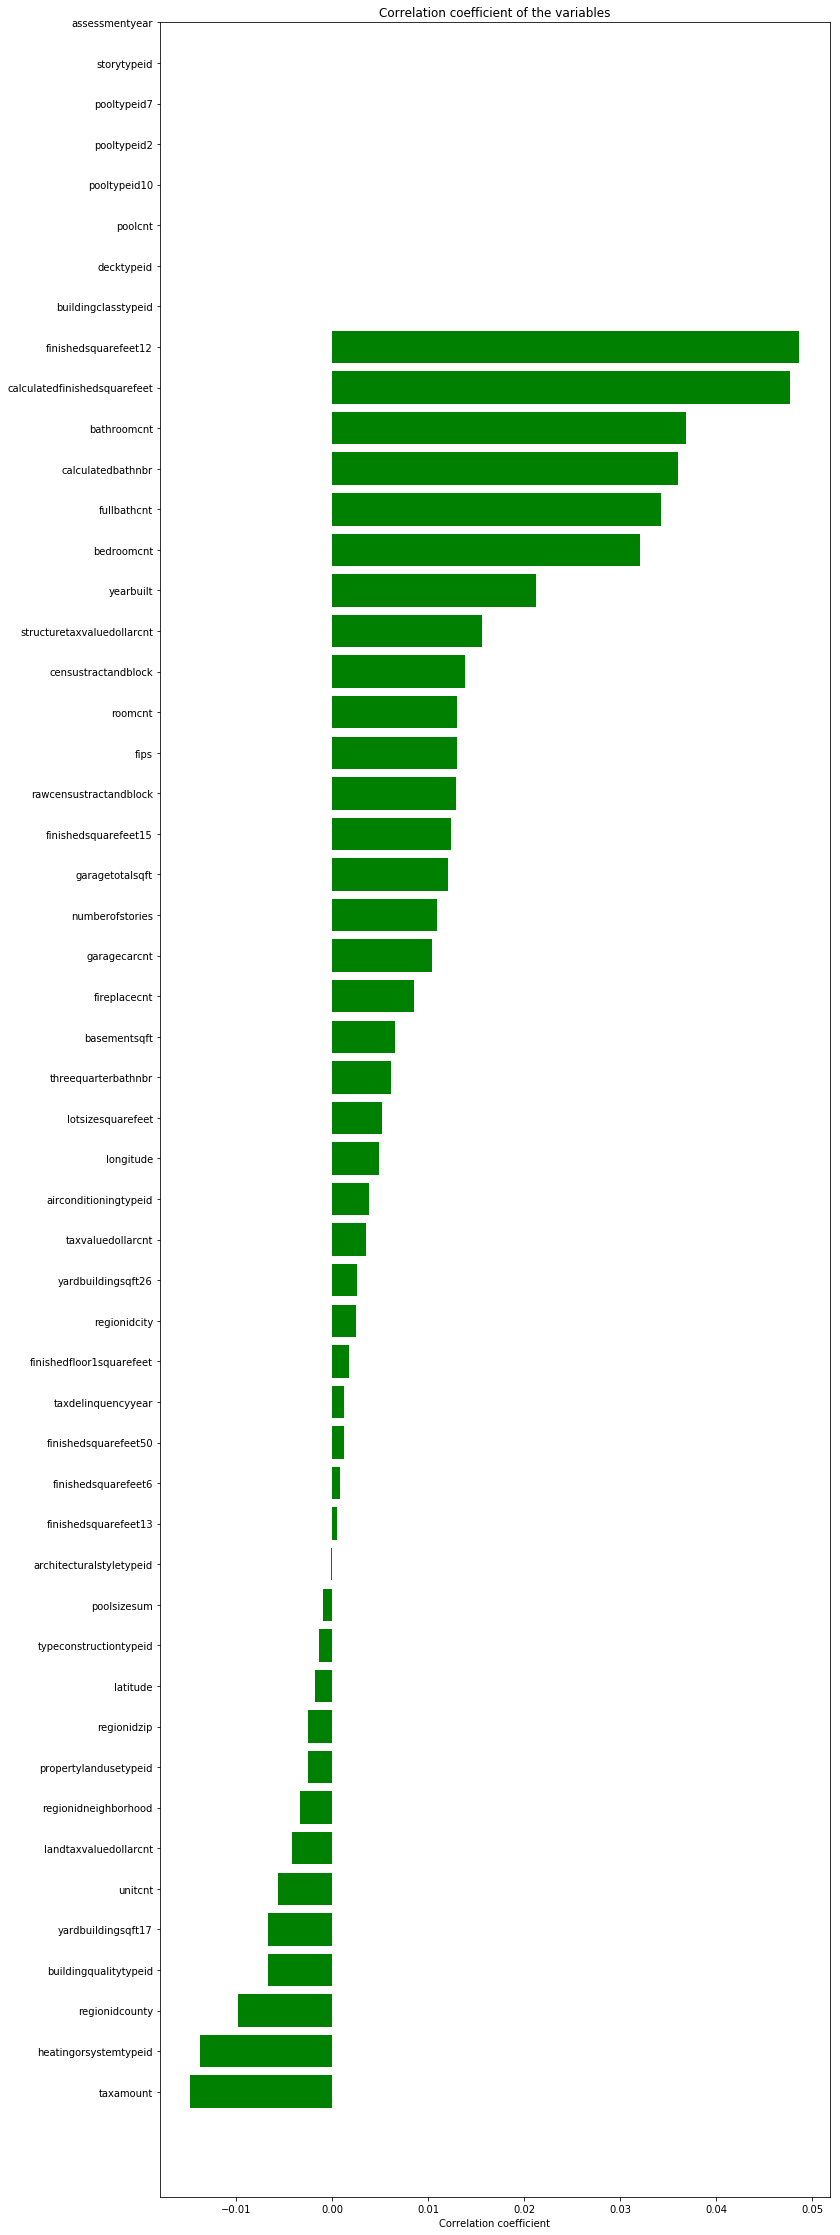

In [38]:
ind = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='g')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")

The correlation of the target variable with the given set of variables are low overall.

There are few variables at the top of this graph without any correlation values. Thats because they have only one unique value and hence no correlation value.

#### Let us take the variables with high correlation values and then do some analysis on them.

In [39]:
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel

,col_labels,corr_values
49,taxamount,-0.014768
21,heatingorsystemtypeid,-0.013732
43,yearbuilt,0.021171
4,bedroomcnt,0.032035
18,fullbathcnt,0.034267
7,calculatedbathnbr,0.036019
3,bathroomcnt,0.036862
10,calculatedfinishedsquarefeet,0.047659
11,finishedsquarefeet12,0.048611


Text(0.5,1,'Important variables correlation map')

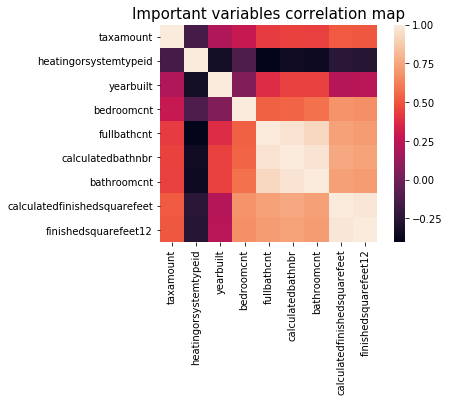

In [40]:
cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = merged_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')

sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)

#### The important variables themselves are very highly correlated.

### finishedsquarefeet12

Text(0.5,1,'Finished square feet 12 Vs Log error')

<Figure size 432x432 with 0 Axes>

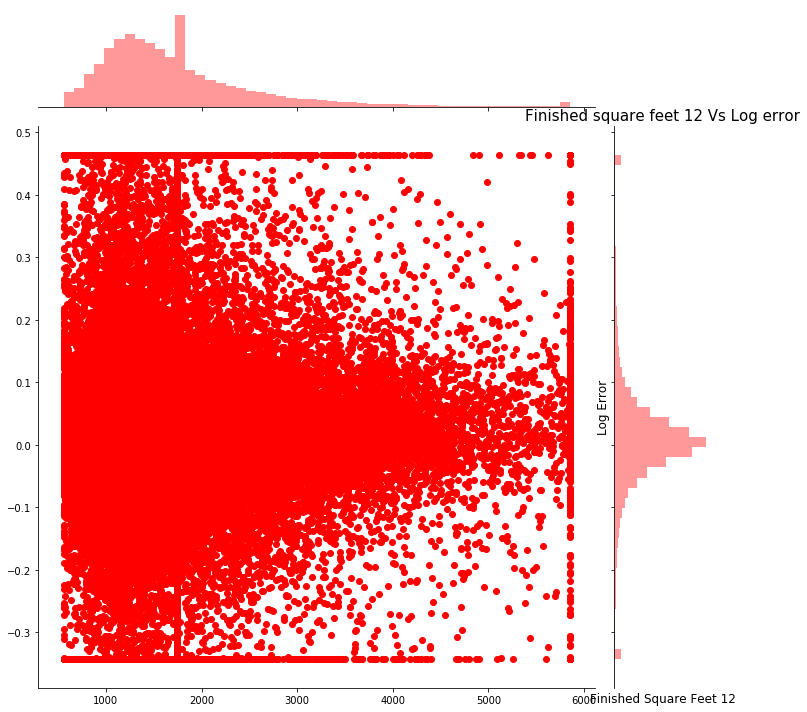

In [41]:
col = "finishedsquarefeet12"
merged_df[col].loc[merged_df[col]> np.percentile(merged_df[col].values, 99.5)] = np.percentile(merged_df[col].values, 99.5)
merged_df[col].loc[merged_df[col]< np.percentile(merged_df[col].values, 0.5)] = np.percentile(merged_df[col].values, 0.5)

plt.figure(figsize=(6,6))
sns.jointplot(x=merged_df.finishedsquarefeet12.values, y=merged_df.logerror.values, size=10, color='r')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)

It can be observed that the range of logerror narrows down with increase in finished square feet 12 variable.

### calculatedfinishedsquarefeet

Text(0.5,1,'Finished sqaure fit Vs Log error')

<Figure size 432x432 with 0 Axes>

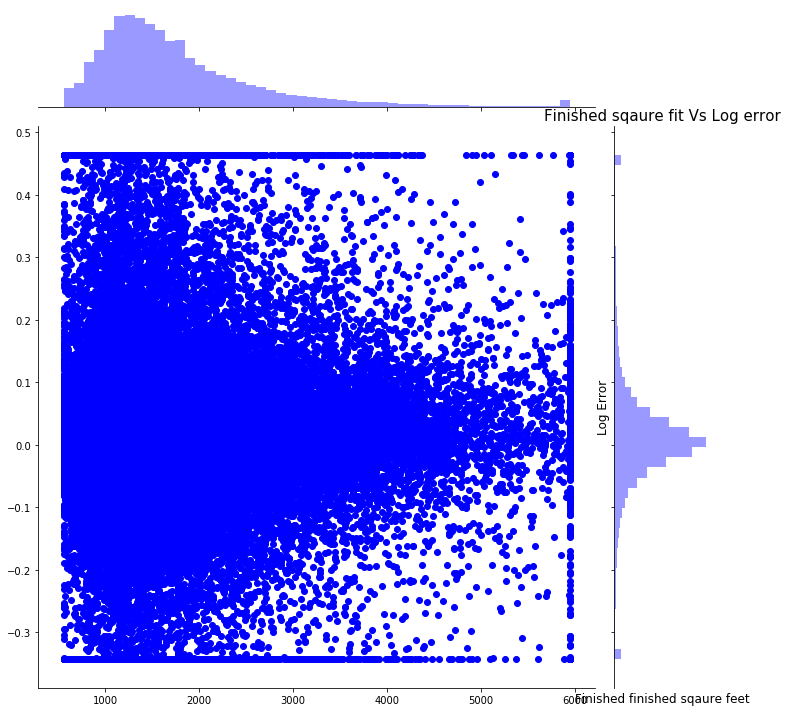

In [42]:
col = "calculatedfinishedsquarefeet"
merged_df[col].loc[merged_df[col]> np.percentile(merged_df[col].values, 99.5)] = np.percentile(merged_df[col].values, 99.5)
merged_df[col].loc[merged_df[col]< np.percentile(merged_df[col].values, 0.5)] = np.percentile(merged_df[col].values, 0.5)

plt.figure(figsize=(6,6))
sns.jointplot(x=merged_df.calculatedfinishedsquarefeet.values, y=merged_df.logerror.values, size=10, color='b')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished finished sqaure feet', fontsize=12)
plt.title("Finished sqaure fit Vs Log error", fontsize=15)

Here as well the distribution is very similar to the previous one

### taxamount

Text(0.5,1,'Tax Amount Vs Log error')

<Figure size 432x432 with 0 Axes>

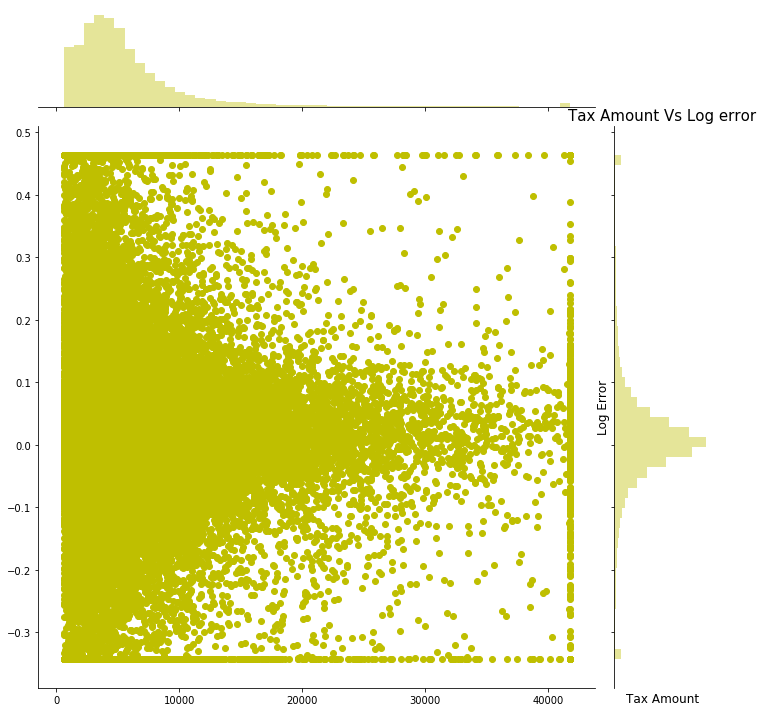

In [43]:
col = "taxamount"
merged_df[col].loc[merged_df[col]> np.percentile(merged_df[col].values, 99.5)] = np.percentile(merged_df[col].values, 99.5)
merged_df[col].loc[merged_df[col]< np.percentile(merged_df[col].values, 0.5)] = np.percentile(merged_df[col].values, 0.5)

plt.figure(figsize=(6,6))
sns.jointplot(x=merged_df.taxamount.values, y=merged_df.logerror.values, size=10, color='y')
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Tax Amount', fontsize=12)
plt.title("Tax Amount Vs Log error", fontsize=15)

Here as well the distribution is very similar to the previous both.

### bathroomcnt

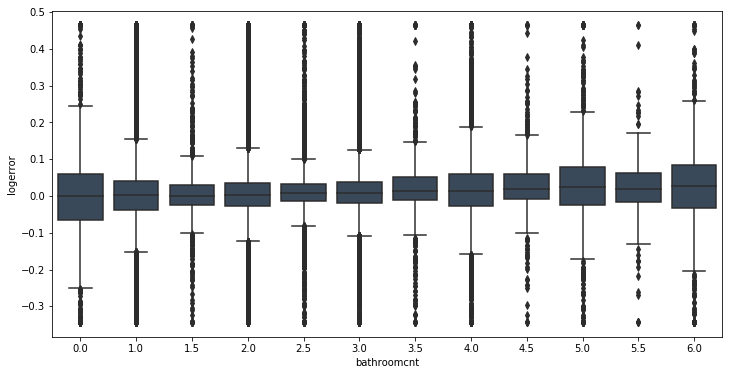

In [44]:
col = "bathroomcnt"
merged_df[col].loc[merged_df[col]> np.percentile(merged_df[col].values, 99.5)] = np.percentile(merged_df[col].values, 99.5)
merged_df[col].loc[merged_df[col]< np.percentile(merged_df[col].values, 0.5)] = np.percentile(merged_df[col].values, 0.5)
plt.figure(figsize = (12,6))
sns.boxplot(x="bathroomcnt", y="logerror", data=merged_df,color="#34495e")

### roomcnt

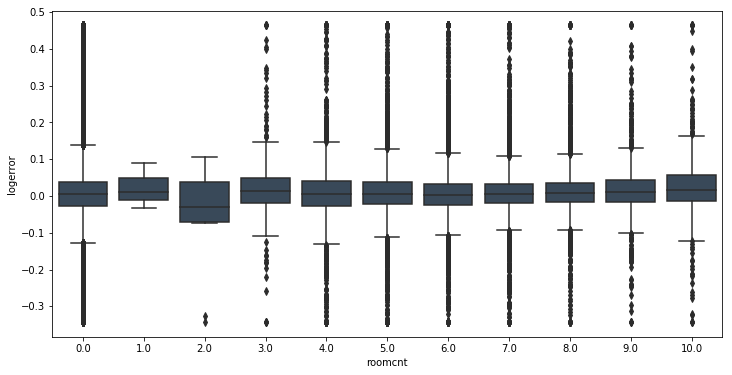

In [45]:
col = "roomcnt"
merged_df[col].loc[merged_df[col]> np.percentile(merged_df[col].values, 99.5)] = np.percentile(merged_df[col].values, 99.5)
merged_df[col].loc[merged_df[col]< np.percentile(merged_df[col].values, 0.5)] = np.percentile(merged_df[col].values, 0.5)
plt.figure(figsize = (12,6))
sns.boxplot(x="roomcnt", y="logerror", data=merged_df,color="#34495e")

### Binding float64 to float32 due to memory constraints

In [47]:
for c, dtype in zip(merged_df.columns, merged_df.dtypes):
    if dtype == np.float64:
        merged_df[c] = merged_df[c].astype(np.float32)

### Preparing data from training models

In [76]:
x_train=merged_df[ merged_df.logerror > -0.4 ]
x_train=merged_df[ merged_df.logerror < 0.4 ]
y_train = x_train['logerror'].values
x_train = x_train.drop(['parcelid', 'logerror', 'transactiondate', 'transaction_month','basementsqft', 'buildingclasstypeid', 'storytypeid', 'finishedsquarefeet13'], axis=1)

### Filling missing values

In [80]:
for i in range(len(x_train.columns)):
    x_train.iloc[:,i] = (x_train.iloc[:,i]).fillna(0)

### Converting categorical columns to numberical columns using label encoding

In [81]:
for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl.fit(list(x_train[c].values))
        x_train[c] = lbl.transform(list(x_train[c].values))

### Using min-max scaling to scale data for Neural Networks model

In [82]:
mmScale = MinMaxScaler()

n = x_train.shape[1]


xtrain = mmScale.fit_transform(x_train)
xtest = mmScale.fit_transform(x_test)

### Defining a simple neural network with 1 hidden layer, rectified linear unit as activation function and mean absolute error as metric

In [84]:
model_n = Sequential()

model_n.add( Dense(n, activation='relu', input_shape=(n,) ) )
model_n.add( Dense(int(0.5*n), activation='relu' ) )
model_n.add(Dense(1, activation='linear'))
model_n.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
        

model_n.fit(xtrain, y_train, epochs=10, batch_size=10)

Epoch 1/10
89111/89111 [==============================] - 17s 190us/step - loss: 0.0077 - mean_absolute_error: 0.0559
Epoch 2/10
89111/89111 [==============================] - 11s 121us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 3/10
89111/89111 [==============================] - 11s 121us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 4/10
89111/89111 [==============================] - 11s 121us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 5/10
89111/89111 [==============================] - 11s 121us/step - loss: 0.0076 - mean_absolute_error: 0.0554
Epoch 6/10
89111/89111 [==============================] - 11s 123us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 7/10
89111/89111 [==============================] - 11s 122us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 8/10
89111/89111 [==============================] - 11s 122us/step - loss: 0.0076 - mean_absolute_error: 0.0553
Epoch 9/10
89111/89111 [==============================] 

In [ ]:
The neural network is probably

In [85]:
split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

In [86]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

In [87]:
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.486204	valid-mae:0.479284
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.397278	valid-mae:0.390462
[20]	train-mae:0.324948	valid-mae:0.318309
[30]	train-mae:0.266555	valid-mae:0.26022
[40]	train-mae:0.219587	valid-mae:0.213588
[50]	train-mae:0.181959	valid-mae:0.176379
[60]	train-mae:0.151975	valid-mae:0.146747
[70]	train-mae:0.128203	valid-mae:0.123344
[80]	train-mae:0.109547	valid-mae:0.105027
[90]	train-mae:0.095056	valid-mae:0.090856
[100]	train-mae:0.083967	valid-mae:0.080044
[110]	train-mae:0.075609	valid-mae:0.07201
[120]	train-mae:0.06942	valid-mae:0.066159
[130]	train-mae:0.064918	valid-mae:0.062023
[140]	train-mae:0.061699	valid-mae:0.059151
[150]	train-mae:0.059427	valid-mae:0.057215
[160]	train-mae:0.057829	valid-mae:0.055936
[170]	train-mae:0.056715	valid-mae:0.055118
[180]	train-mae:0.055939	valid-mae:0.054606
[190]	train-mae:0.055407	valid-mae

In [95]:
def MAE(y, ypred):
    #logerror=log(Zestimate)−log(SalePrice)
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)

In [98]:
reg = LinearRegression(n_jobs=-1)
reg.fit(x_train, y_train); print('fit...')
print(MAE(y_valid, reg.predict(x_valid)))

fit...
0.05476260390517431
